In [1]:
# Imports:

import sys
import os
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import matplotlib.colors as mcolors
from collections import Counter

sys.path.append('/home/563/ls7238/code/australia_precipitation/module')
import helper_funcs
importlib.reload(helper_funcs)

<module 'helper_funcs' from '/home/563/ls7238/code/australia_precipitation/module/helper_funcs.py'>

In [2]:
# Pulling out capital city longest running stations for testing

# ID: 066037	Name: SYDNEY AIRPORT AMO
# ID: 086282	Name: MELBOURNE AIRPORT
# ID: 014015	Name: DARWIN AIRPORT
# ID: 040913	Name: BRISBANE
# ID: 009225	Name: PERTH METRO
# ID: 094029	Name: HOBART (ELLERSLIE ROAD)

tester_stations = ['/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NSW/NSW_066037.nc', #0
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/VIC/VIC_086282.nc', #1
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NT/NT_014015.nc',   #2
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/QLD/QLD_040913.nc',  #3
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/WA/WA_009225.nc',    #4
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/TAS/TAS_094029.nc']    #5

print(nc.Dataset(tester_stations[0]))

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Record_identifier: st
    Station_Number: 066037
    Rainfall_district_code: 66
    Station_Name: SYDNEY AIRPORT AMO                      
    Station_opened(MM-YYYY): 01/1929
    Station_closed(MM-YYYY):        
    Latitude: -33.9465
    Longitude: 151.1731
    lat-lon_record_method: SURVEY         
    State: NSW
    Height_station(ABSL): 6.0
    Height_barometer(ABSL):    5.0
    WMO_Number: 94767
    First_year: 1948
    Lastest_year: 2024
    Percentage_of_complete: 37
    Percentage_of_Y: 0
    Percentage_of_N: 100
    Percentage_of_W: 0
    Percentage_of_S: 0
    Percentage_of_I: 0
    EoR_indicator: #
    author: Dongqi Lin (dongqi.lin@monash.edu)
    dimensions(sizes): time(1328268)
    variables(dimensions): int64 time(time), float64 prcp(time), <class 'str'> local_time(time), int64 aws_flag(time), float64 quality_flag(time), float64 prcp_inst(time)
    groups: 


In [3]:
metdf = helper_funcs.read_stations_metadata(tester_stations)

In [4]:
metdf

,Station Number,Station Name,State,Latitude,Longitude,Start Year,End Year,Percentage Complete (from file),Record Length
0,066037,SYDNEY AIRPORT AMO,NSW,-33.9465,151.1731,1948,2024,37,77
1,086282,MELBOURNE AIRPORT,VIC,-37.6654,144.8322,1970,2024,46,55
2,014015,DARWIN AIRPORT,NT,-12.4239,130.8925,1985,2024,63,40
3,040913,BRISBANE,QLD,-27.4808,153.0389,1999,2024,99,26
4,009225,PERTH METRO,WA,-31.9192,115.8728,1993,2024,95,32
5,094029,HOBART (ELLERSLIE ROAD),TAS,-42.8897,147.3278,1994,2024,81,31


In [5]:
# Function for calculating the completeness (%NaN) of a list of files:


def calculate_completeness(file_list, varname="prcp_inst"):
    '''
    Function calculates the percentage complete of a life of files by looking at the amount of non-NaN values in the file
    Returns: a list of tuples, one for each station, containing the filepath, station ID, and % complete.
    '''
    # Inititialise list to store results in
    results = []

    for filepath in file_list:
        ds = xr.open_dataset(filepath)

        # just in case
        ds = ds.sortby("time")
        station_id = getattr(ds, 'Station_Number')

        # Count non-NaN values and all values
        valid_count = ds[varname].count().item()
        total_count = ds[varname].size
        
        # See how many of all values are Non-NaN
        percent_complete = 100 * (valid_count / total_count)

        # Add percent complete with corresponding file path and station id to results
        results.append((filepath, station_id, percent_complete))

        ds.close()

    return results


In [7]:
before = calculate_completeness(tester_stations)
for x in before:
    print(f'Station ID: {x[1]}, percent complete: {x[2]}')

Station ID: 066037, percent complete: 36.12749836629355
Station ID: 086282, percent complete: 45.3016170893658
Station ID: 014015, percent complete: 61.2126563394953
Station ID: 040913, percent complete: 98.65363120718682
Station ID: 009225, percent complete: 93.81604725856691
Station ID: 094029, percent complete: 73.63606545428041


In [8]:

def find_longest_consecutive(good_years):
    """
    Helper function for check_completeness function
    Finds start and end year of the longest run of True values
    Arguments:
    - good_years: pd.Series indexed by year, values True/False
    Returns:
    - best_start, best_end: integers (years) of the longest consecutive True run
    """
    # List of actual years in df:
    years = good_years.index.values
    # True/false values for those years: (true when year is above 80% completeness)
    mask = good_years.values

    # Initialise counters:
    best_start, best_end = None, None
    current_start, current_end = None, None
    max_len, current_len = 0, 0

    # loop through the indicies for and the true/false values 
    for i, is_good in enumerate(mask):     
        if is_good:                          #ie. if the year is true
            if current_start is None:
                current_start = years[i]
                current_end = years[i]
                current_len = 1
            else:
                # Check if current year is consecutive
                if years[i] == current_end + 1:
                    current_end = years[i]
                    current_len += 1
                else:
                    # Gap detected → start new run
                    current_start, current_end, current_len = years[i], years[i], 1

            if current_len > max_len:
                best_start, best_end = current_start, current_end
                max_len = current_len
        else:
            current_start, current_end, current_len = None, None, 0

    return best_start, best_end


def check_completeness(station_files, output_dir="complete_stations", completeness_threshold=0.8):
    """
    Cleans station NetCDF files by keeping only the longest consecutive period
    of years with sufficient completeness, and saves cleaned datasets.
    
    Arguments:
    - station_files: list of paths to NetCDF files
    - output_dir: directory to save cleaned NetCDF files
    - completeness_threshold: minimum % of valid values per year
    """
    os.makedirs(output_dir, exist_ok=True)

    for file in station_files:
        ds = xr.open_dataset(file)

        # Count valid (non-NaN) entries per year
        yearly_counts = ds['prcp_inst'].groupby('time.year').count()

        # Total possible entries per year
        yearly_totals = ds['time'].groupby('time.year').count()

        # Fraction completeness
        yearly_fraction = yearly_counts / yearly_totals

        # Mark good years (≥ threshold)
        good_years_da = yearly_fraction >= completeness_threshold
        # Convert to pandas Series with year as index
        good_years = good_years_da.to_series()  # now .index is the years

        # Find longest consecutive period with helper function
        start, end = find_longest_consecutive(good_years)
        if start is None or end is None:
            print(f"No valid period found for {file}")
            ds.close()
            continue

        # Slice dataset for longest valid period
        ds = ds.sortby("time")
        ds_good = ds.sel(time=slice(f"{start}-01-01", f"{end}-12-31"))

        # Save cleaned dataset
        station_name = os.path.basename(file).replace(".nc", "")
        out_file = os.path.join(output_dir, f"{station_name}_cleaned.nc")
        ds_good.to_netcdf(out_file)
        ds.close()

        print(f"Saved {out_file} with period {start}-{end}")


In [9]:
check_completeness(tester_stations, output_dir="testing_complete_checker")

Saved testing_complete_checker/NSW_066037_cleaned.nc with period 1998-2024
Saved testing_complete_checker/VIC_086282_cleaned.nc with period 2000-2024
Saved testing_complete_checker/NT_014015_cleaned.nc with period 2000-2024
Saved testing_complete_checker/QLD_040913_cleaned.nc with period 1999-2024
Saved testing_complete_checker/WA_009225_cleaned.nc with period 1996-2024
Saved testing_complete_checker/TAS_094029_cleaned.nc with period 2003-2024


In [10]:

complete_testers = []
for root, dirs, files in os.walk('/home/563/ls7238/data/testing_complete_checker'):
    for file in files:
        if file.endswith('.nc'):
            complete_testers.append(os.path.join(root, file))

complete_testers

['/home/563/ls7238/data/testing_complete_checker/NSW_066037_cleaned.nc',
 '/home/563/ls7238/data/testing_complete_checker/VIC_086282_cleaned.nc',
 '/home/563/ls7238/data/testing_complete_checker/NT_014015_cleaned.nc',
 '/home/563/ls7238/data/testing_complete_checker/QLD_040913_cleaned.nc',
 '/home/563/ls7238/data/testing_complete_checker/WA_009225_cleaned.nc',
 '/home/563/ls7238/data/testing_complete_checker/TAS_094029_cleaned.nc']

In [11]:
test = calculate_completeness(complete_testers)
for x in test:
    print(f'Station ID: {x[1]}, percent complete: {x[2]}')

Station ID: 066037, percent complete: 95.68791149266917
Station ID: 086282, percent complete: 96.61333327134479
Station ID: 014015, percent complete: 97.24510669952113
Station ID: 040913, percent complete: 98.65363120718682
Station ID: 009225, percent complete: 98.41437991321364
Station ID: 094029, percent complete: 97.7750351582053


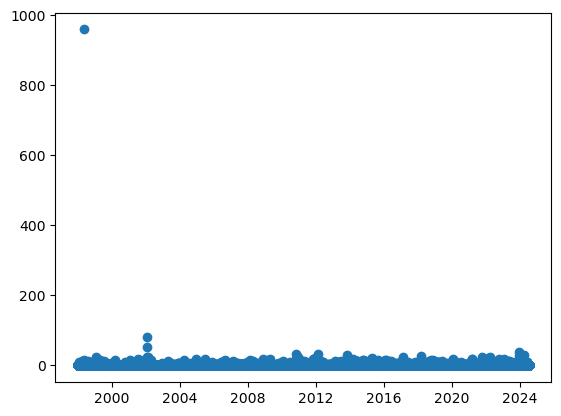

In [17]:
ds = xr.open_dataset(complete_testers[0])
rain = ds['prcp_inst']
time = ds['time']
plt.scatter(time, rain)
#print(rain.argmax())
#print(qual[869093].values)
ds.close()